## What's new in COBRApy?

This is a short demo notebook for the new features in cobrapy 0.6.

First let's create a small cobra model of the *E. coli* central carbon metabolism.

In [3]:
from cobra.test import create_test_model

ecoli = create_test_model("textbook")
ecoli.optimize()

<Solution 0.874 at 0x7fee3cbb1240>

### Summaries

Summary functions are not really a feature of 0.6 but many people are still not aware of them. so let's reiterate the here :)

In [4]:
ecoli.summary()

IN FLUXES        OUT FLUXES    OBJECTIVES
---------------  ------------  ----------------------
o2_e      21.8   h2o_e  29.2   Biomass_Ecol...  0.874
glc__D_e  10     co2_e  22.8
nh4_e      4.77  h_e    17.5
pi_e       3.21


The basic summary gives a nice overview of the used imports and exports as well as the current objective. We can also get a summary on the level of a single metabolite.

In [8]:
ecoli.metabolites.g6p_c.summary()

PRODUCING REACTIONS -- D-Glucose 6-phosphate (g6p_c)
----------------------------------------------------
%       FLUX  RXN ID      REACTION
----  ------  ----------  --------------------------------------------------
100%  10      GLCpts      glc__D_e + pep_c --> g6p_c + pyr_c

CONSUMING REACTIONS -- D-Glucose 6-phosphate (g6p_c)
----------------------------------------------------
%       FLUX  RXN ID      REACTION
----  ------  ----------  --------------------------------------------------
50%    4.96   G6PDH2r     g6p_c + nadp_c <=> 6pgl_c + h_c + nadph_c
49%    4.86   PGI         g6p_c <=> f6p_c
2%     0.179  Biomass...  1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0....


This gives us basic information about the consuming reactions and how the fluxes are distributed between them.

### New solver interface

COBRApy now used [optlang](https://github.com/biosustain/optlang) to manage the underlying solvers which gives much nicer interfaces and some general improvements. All COBRA models now have a `solver` attribute which is a full-fledged optlang problem. As a consequence the objective can now be an optlang expression giving much more possibilities for custom objectives.

In [38]:
ecoli = create_test_model("textbook")
print(ecoli.objective)
ecoli.solver

Maximize
-1.0*Biomass_Ecoli_core_reverse_2cdba + 1.0*Biomass_Ecoli_core


 Even if you don't want to create complex constraints you might appreciate one immediate effect of the new interface: solution basis reuse is enabled automatically. 

In [11]:
# first
%time ecoli.optimize()

#second
%time ecoli.optimize()

CPU times: user 1.89 ms, sys: 0 ns, total: 1.89 ms
Wall time: 1.9 ms
CPU times: user 1.13 ms, sys: 0 ns, total: 1.13 ms
Wall time: 1.16 ms


<Solution 0.874 at 0x7fee3c917898>

If you just want a single flux or the objective value using the optlang interface directly can be much more performant.

In [21]:
%time ecoli.solver.optimize()

%time print(ecoli.objective.value)

CPU times: user 88 µs, sys: 23 µs, total: 111 µs
Wall time: 116 µs
0.8739215069684307
CPU times: user 67 µs, sys: 0 ns, total: 67 µs
Wall time: 61 µs


Internally we now use a irreversible formulation of the problem which makes implementig many algorithms much easier since you do not have to convert between reversible and irreversible representations anymore. However, you will never have to deal with that explicitly and fluxes can still be reversible as always. To see the internal representation of a flux there is the new `flux_expression` and variables.

In [39]:
atpm = ecoli.reactions.ATPM
print(atpm.flux_expression)
print(atpm.forward_variable)  # optlang prints variables nicely together with their bounds

-1.0*ATPM_reverse_5b752 + 1.0*ATPM
8.39 <= ATPM <= 1000.0


However you do not have to interact with the optlang interface at all. Everything is automatically handled and you can use the old flux bounds.

In [16]:
atpm.bounds

(8.39, 1000.0)

If you need to you can create variables, constraints and objectives directly. No more weird mock reaction to implement your custom constraints. For instance let us create a new variable whose value will be fixed to half of the ATPM reaction flux. For that we first create a new unbounded variable and than add a constraint to make the variable equal to half the flux. Constraints in optlang can be defined by linear statements directly.

In [40]:
variable = ecoli.problem.Variable("test_var")
constraint = ecoli.problem.Constraint(0.5 * atpm.flux_expression - variable, lb=0, ub=0)
ecoli.add_cons_vars([variable, constraint])
ecoli.optimize()
print(atpm.flux)
print(ecoli.variables.test_var.primal) # This is how you can access non-flux variables

8.39
4.195


### Solution

The solution object has also received an overhaul in COBRApy 0.6. the solution is not a propert of the model anymore which means it can be saved seperattely and contains a snapshot of the solution at the moment it was obtained. Fluxes and shadow costs are now saved as pandas Series giving a much nicer representation.

ACALD     0.00000
ACALDt    0.00000
ACKr      0.00000
ACONTa    6.00725
ACONTb    6.00725
Name: fluxes, dtype: float64
ATPM flux #1: 8.39
ATPM flux #2: 8.39
Objective value: 0.8739215069684307


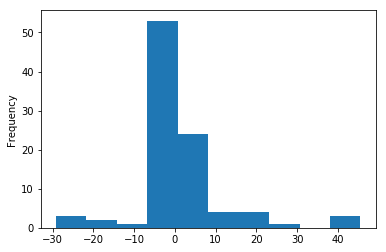

In [50]:
%matplotlib inline

ecoli = create_test_model("textbook")

sol = ecoli.optimize()
print(sol.fluxes.head())
sol.fluxes.plot("hist")
print("ATPM flux #1:", sol.fluxes.ATPM) # or access directly
print("ATPM flux #2:", sol["ATPM"])
print("Objective value:", sol.objective_value)

### Context managers for temporary changes

One pattern we observed a lot in the daily Systems Biology workflow was to take a model, make some changes, optimize, reset the model and repeat with other changes. Previously, you would have to track those changes by hand. For instance by only applying them to a copy of the model of reading the model again from a file. This is not only slow but also cumbersome. COBRApy 0.6 comes with new context managers that allow you to apply changes within a `with`-block and have them reverted automatically on exit. That may sound complicated but is better explained with a small example.

Let us assume we want to quickly get the maximum ATPM flux in the model.

In [52]:
with ecoli:
    ecoli.objective = "ATPM"
    print(ecoli.optimize())
print(ecoli.objective)
print(ecoli.optimize())

<Solution 175.000 at 0x7fee37351470>
Maximize
-1.0*Biomass_Ecoli_core_reverse_2cdba + 1.0*Biomass_Ecoli_core
<Solution 0.874 at 0x7fee37351fd0>


As we can see the objective was applied within the `with`-block but reset automatically afterwards to the old objective.

Another example could be simulating a knockout of several reaction.

In [56]:
with ecoli:
    ecoli.reactions.ACALD.knock_out()
    print(ecoli.reactions.ACALD.bounds)
    ecoli.reactions.ACONTa.knock_out()
    print(ecoli.optimize())
print(ecoli.reactions.ACALD.bounds)

(0, 0)
<Solution -0.000 at 0x7fee3c5304a8>
(-1000.0, 1000.0)


All operations in the normal API and many more are supported by the context manager. Resettable operations include:

- adding and deleting reactions or metabolites
- changing the objective
- changing flux bounds
- adding or removing optlang variables and constraints

### Loopless solutions

COBRApy now inludes several strategies to obtain loopless solutions quickly. The new function `loopless_solution` can be used to convert a normal flux solution to a loopless one.

In [60]:
from cobra.flux_analysis import loopless_solution

%time ll_sol = loopless_solution(ecoli)
ll_sol.fluxes.head()

CPU times: user 14.1 ms, sys: 46 µs, total: 14.1 ms
Wall time: 13.7 ms


ACALD     0.00000
ACALDt    0.00000
ACKr      0.00000
ACONTa    6.00725
ACONTb    6.00725
Name: fluxes, dtype: float64

Additionally flux variability analysis now supports requesting only loopless solutions as well. Our *E. coli* model actually has a loop in the SUCDi reaction which we can see easily.

In [67]:
from cobra.flux_analysis import flux_variability_analysis

vari = flux_variability_analysis(ecoli)
print(vari.loc["SUCDi"], "\n")

ll_vari = flux_variability_analysis(ecoli, loopless=True)
print(ll_vari.loc["SUCDi"])

maximum    1000.000000
minimum       5.064376
Name: SUCDi, dtype: float64 

maximum    5.064376
minimum    5.064376
Name: SUCDi, dtype: float64


So the maximum flux of 1000 for that reaction is only obtainable with thermodinamically infeasible loop.

### Flux sampling

COBRApy now also includes algorithms for flux sampling which try to generate uniform samples of the flux space. We currently support the artificial-centering hit and run (ACHR) and OptGP algorithms. Here, OptGP can use multiple processes to generate samples in parallel. The easiest access is via the new `sample` function.

In [71]:
from cobra.flux_analysis import sample

%time s = sample(ecoli, 100, processes=2) # for OptGP

%time s = sample(ecoli, 100, method="achr") # for ACHR

s.head()

CPU times: user 195 ms, sys: 411 ms, total: 607 ms
Wall time: 448 ms
CPU times: user 947 ms, sys: 911 ms, total: 1.86 s
Wall time: 822 ms


,ACALD,ACALDt,ACKr,ACONTa,ACONTb,ACt2r,ADK1,AKGDH,AKGt2r,ALCD2x,...,RPI,SUCCt2_2,SUCCt3,SUCDi,SUCOAS,TALA,THD2,TKT1,TKT2,TPI
0,-1.669933,-0.084543,-3.104383,9.179873,9.179873,-3.104383,2.276213,7.788044,-0.283664,-1.585390,...,-1.289981,25.918976,26.222244,683.054270,-7.788044,1.253918,6.985417,1.253918,1.239415,7.680271
1,-0.052297,-0.051879,-1.094454,12.308158,12.308158,-1.094454,1.559318,7.355370,-0.190183,-0.000418,...,-0.849656,18.903149,21.934474,558.616614,-7.355370,0.814505,24.820183,0.814505,0.800370,8.590462
2,-0.084909,-0.046229,-1.394200,7.010548,7.010548,-1.394200,6.907227,5.808256,-0.301173,-0.038680,...,-2.625686,35.666383,37.377161,492.495576,-5.808256,2.436915,21.969261,2.436915,2.361003,7.197315
3,-1.091184,-0.037253,-1.022650,8.543145,8.543145,-1.022650,7.048405,7.261570,-0.015469,-1.053930,...,-1.111562,32.301657,33.400928,419.614250,-7.261570,1.010259,2.158159,1.010259,0.969521,7.519662
4,-2.515973,-0.711711,-0.703389,9.217496,9.217496,-0.703389,12.209321,6.511779,-0.556013,-1.804262,...,-1.913000,23.711640,24.242527,429.978781,-6.511779,1.848988,4.701708,1.848988,1.823246,7.863198


Note that this actually generates 10,000 samples since sampling by default only records every 100th sample to improve mixing. This can be controlled with the `thinning` parameter.

For larger models you might want to have more control over the sampler which can be achieved by using the `ACHRSampler` and `OptGPSampler` classes.

In [72]:
from cobra.flux_analysis.sampling import OptGPSampler

%time optgp = OptGPSampler(ecoli, processes=2, thinning=50)

%time s = optgp.sample(100)

CPU times: user 221 ms, sys: 424 ms, total: 645 ms
Wall time: 171 ms
CPU times: user 6.46 ms, sys: 9.07 ms, total: 15.5 ms
Wall time: 156 ms


As you can see buidling the sampler may take up significant time due to the generation of a complete set of initial search directions. So it is a good idea to make extensive use of an already created sampler object. The sampler object has a lot of attributes detailing the sampling process in detail.

In [74]:
s = optgp.sample(42)

print("Sampled a total of", optgp.n_samples, "samples.")

Sampled a total of 184 samples.


It also comes with a validation function to see whether a sample is valid.

In [79]:
# should not be valid
import numpy as np
bad = np.ones(len(ecoli.reactions))
print(optgp.validate(bad))

good = sol.fluxes
print(optgp.validate(good))

['le']
['v']


The codes returned by validate are:

- "v" = valid sample
- "l" or "u" = lower or upper bound violation
- "e" equality violation, for instance if Sv != 0

Furthermore, the sampler will respect additional variables and constraints defined in the model.